## Predict Recyclable vs Organic using DenseNet and then transfer images to second model to classify them into glass, cardboard etc.

### The code for DenseNet training and preprocessing was referred to from the official documentiation and tutorial https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Creating image transforms for the test and train data for DenseNet Model

Referred to from link https://www.programcreek.com/python/example/117696/torchvision.transforms.RandomResizedCrop

In [1]:
import torchvision.transforms as transforms

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [2]:
import torch
from torchvision import datasets
train_on_gpu = torch.cuda.is_available()

train_set = datasets.ImageFolder('./DATASET/TRAIN', transform=train_transforms)
test_set = datasets.ImageFolder('./DATASET/TEST', transform=test_transforms)

Create Random Subsets for validation. Keeping 20% data for validation purpose

In [3]:
import numpy as np

train_len = len(train_set)
indexes = list(range(train_len))
np.random.shuffle(indexes)
split = int(np.floor(0.2 * train_len))
train_i, valid_i = indexes[split:], indexes[:split]

Subset Creation and sampling Code reffered to from https://www.programcreek.com/python/example/89637/torch.utils.data.sampler.SubsetRandomSampler Example 6

In [4]:
from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(train_i)
valid_sampler = SubsetRandomSampler(valid_i)

trainl = torch.utils.data.DataLoader(train_set,sampler=train_sampler, num_workers=0,  batch_size=32)
validl = torch.utils.data.DataLoader(train_set, sampler=valid_sampler, num_workers=0, batch_size=32)
testl = torch.utils.data.DataLoader(test_set, num_workers=0, batch_size=32)

In [5]:
print(len(trainl))

565


Define Output Classes O-Organic, R-Recyclable

In [6]:
op_labels=['O','R']

In [7]:
import matplotlib.pyplot as plt

def displayImage(i):
    i = (i / 2)
    i += + 0.5 
    plt.imshow(np.transpose(i, (1, 2, 0))) 

Show some random image samples with their corresponding classes after they have been preprocessed

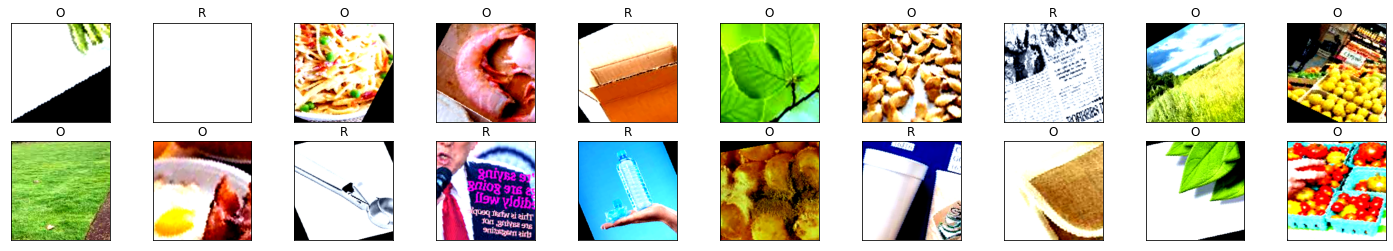

In [8]:
dataiterator = iter(trainl)
images, labels = dataiterator.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))

for i in np.arange(20):
    axes = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    displayImage(images[i])
    axes.set_title(op_labels[labels[i]])

torch.Size([32, 3, 224, 224])
tensor(0)


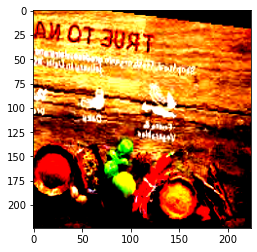

In [9]:
batch = next(iter(trainl))
print(batch[0].shape)
plt.imshow(batch[0][0].permute(1, 2, 0))
print(batch[1][0])

Load DenseNet Pretrained Model.

How to finetune pretrained models reffered to from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [10]:
from torchvision import models
from torch import optim
import torch.nn.functional as F

modelDN = models.densenet121(pretrained=True)
modelDN

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

Transfer Learning refers to the process of using already existing pre-trained models for other applications by tweaking the last few layers and using it to classify our desired classes. The models once trained work very well as feature detectors for images which were not used for training them. Transfer learning is making the use of a pre-trained network on images which were originally not in training set .Transfer learning will be leveraged in order to train a network that can classify our organic and recyclable waste photos trying to obtain the highest accuracy possible.

Add linear fully connected layers to complete the densenet 121 pretrained model.

In [11]:
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

modelDN = models.densenet121(pretrained=True)

for p in modelDN.parameters():
    p.requires_grad = False
    
modelDN.classifier = nn.Sequential(nn.Linear(1024, 512), 
                                   nn.ReLU(), 
                                   nn.Dropout(0.2), 
                                   nn.Linear(512, 2), 
                                   nn.LogSoftmax(dim=1))

loss_criteria = nn.NLLLoss()

adamopt = optim.Adam(modelDN.classifier.parameters(), lr=0.005)

modelDN.to(device);

Fit the model for a total of 10 epochs at each step checking if the loss is lower than the previous loss we save the model

In [12]:
no_epochs = 10

loss_min = np.Inf

for i in range(1, no_epochs+1):
    print("Epoch : ", i)
    loss_train, loss_validation = 0.0, 0.0
    
    modelDN.train()
    
    for image, label in trainl:
        if train_on_gpu:
            image, label = image.cuda(), label.cuda()

        adamopt.zero_grad()
        op = modelDN(image)
        loss = loss_criteria(op, label)
        loss.backward()
        adamopt.step()
        loss_train += loss.item()*image.size(0)
        

    modelDN.eval()
    for image, label in validl:
        if train_on_gpu:
            image, label = image.cuda(), label.cuda()

        output = modelDN(image)
        loss = loss_criteria(output, label)
        loss_validation += loss.item()*image.size(0)
    

    loss_train = loss_train/len(trainl.sampler)
    loss_validation = loss_validation/len(validl.sampler)
    print('Training Loss:', loss_train, '\tValidation Loss:',loss_validation)
    
    if loss_validation <= loss_min:
        torch.save(modelDN.state_dict(), 'wasteClassificationDensenet.pt')
        loss_min = loss_validation

Epoch :  1
Training Loss: 0.3063534149145198 	Validation Loss: 0.272078349182369
Epoch :  2
Training Loss: 0.2679913968356306 	Validation Loss: 0.21401897786145516
Epoch :  3
Training Loss: 0.27502981684119693 	Validation Loss: 0.20232473929406058
Epoch :  4
Training Loss: 0.2530691530774233 	Validation Loss: 0.21976297523113006
Epoch :  5
Training Loss: 0.25604387001111134 	Validation Loss: 0.21280979914656767
Epoch :  6
Training Loss: 0.2488162257759581 	Validation Loss: 0.20897335275109355
Epoch :  7
Training Loss: 0.24784830669566424 	Validation Loss: 0.19491837271456178
Epoch :  8
Training Loss: 0.2453424915252016 	Validation Loss: 0.20069871832292976
Epoch :  9
Training Loss: 0.2595710424211478 	Validation Loss: 0.20516935792745006
Epoch :  10
Training Loss: 0.24162059554814921 	Validation Loss: 0.19977944851555723


Load Saved model weights which were save when training

In [14]:
modelDN.load_state_dict(torch.load('wasteClassificationDensenet.pt'))

<All keys matched successfully>

Check accuracy on test data and save the images which are classified as recyclable in order to be passed into the second model

In [19]:
recyclableImages = []
loss_test = 0.0
correct_label = list(0. for i in range(10))
total_count = list(0. for i in range(10))

modelDN.eval()

for image, opclass in testl:
    if train_on_gpu:
        image, opclass = image.cuda(), opclass.cuda()

    output = modelDN(image)
    loss = loss_criteria(output, opclass)
    loss_test += loss.item()*image.size(0)
    x, pred = torch.max(output, 1)    
    #print(pred)
    correct_tensor = pred.eq(opclass.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    label = opclass.data[0]
    correct_label[label] += correct[0].item()
    total_count[label] += 1

    label = opclass.data[1]
    correct_label[label] += correct[1].item()
    total_count[label] += 1
    
    # Save images to be passed onto next model to further classify them
    if label == 1:
        recyclableImages.append(image)

loss_test = loss_test/len(testl.dataset)
print('Test Loss:', loss_test)


print('Test Accuracy of \t', op_labels[0], ':',100 * correct_label[0] / total_count[0],'%' 
      , '(' ,  np.sum(correct_label[0]), '/' ,np.sum(total_count[0]),')')
print('Test Accuracy of \t', op_labels[1], ':',100 * correct_label[1] / total_count[1],'%' 
      , '(' ,  np.sum(correct_label[1]), '/' ,np.sum(total_count[1]),')')

print('\nTest Accuracy (Mean): \t', 100. * np.sum(correct_label) / np.sum(total_count), '%',
    '(',int(np.sum(correct_label)),'/',int(np.sum(total_count)),')')

Test Loss: 0.13664489767765808
Test Accuracy of 	 O : 98.86363636363636 % ( 87.0 / 88.0 )
Test Accuracy of 	 R : 90.0 % ( 63.0 / 70.0 )

Test Accuracy (Mean): 	 94.9367088607595 % ( 150 / 158 )


In [22]:
dataiterator = iter(testl)
images, labels = dataiterator.next()
images.numpy()


if train_on_gpu:
    images = images.cuda()

In [23]:
output = modelDN(images)

y, predictions = torch.max(output, 1)
preds = np.squeeze(predictions.numpy()) if not train_on_gpu else np.squeeze(predictions.cpu().numpy())

Vizualize predictions

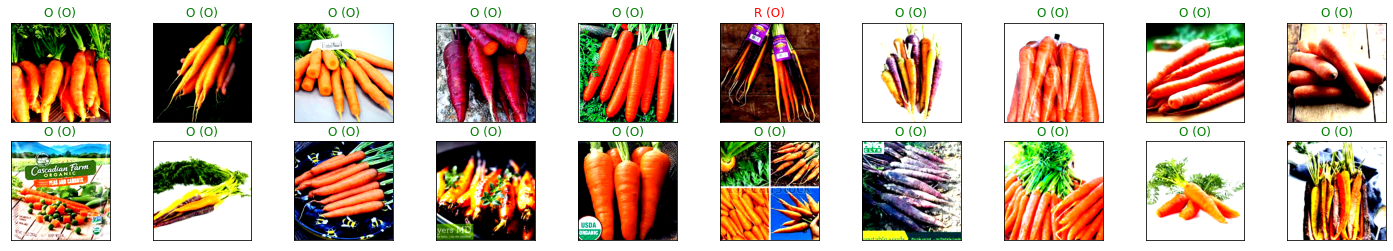

In [24]:
figure = plt.figure(figsize=(30, 5))
for i in np.arange(20):
    axes = figure.add_subplot(2, 25/2, i+1, xticks=[], yticks=[])
    displayImage(images.cpu()[i])
    axes.set_title("{} ({})".format(op_labels[preds[i]], op_labels[labels[i]]),
                 color=("green" if preds[i]==labels[i].item() else "red"))

As the Densenet model outperforms the CNN model developed earlier we will use this as a basis to feed data into the next model which is developed below.

### Second model which will classify recyclable trash into subcategories

In [25]:
import glob, os, random
image_path = './DATASET/Garbage classification'

images = glob.glob(os.path.join(image_path, '*/*.jpg'))

print(len(images))

2527


Loading images as array

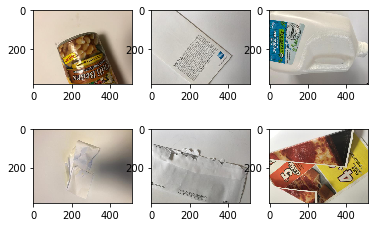

In [26]:
from keras.preprocessing.image import load_img, img_to_array, array_to_img

for i, path in enumerate(random.sample(images, 6)):
    img = img_to_array(load_img(path), dtype=np.uint8)
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

Image augmentation and preprocessing using ImageDataGenerator

Using ImageDataGenerator to expand the training dataset in order to improve the performance and ability of the model to generalize.
Code referred from https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [27]:
from keras.preprocessing.image import ImageDataGenerator

train_imggen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    height_shift_range=0.1,
    width_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    rescale=1./255,
    validation_split=0.1
)

test_imggen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_gen = train_imggen.flow_from_directory(
    image_path,
    batch_size=16,
    class_mode='categorical',
    subset='training',
    target_size=(250, 250),
    seed=0
)

val_gen = test_imggen.flow_from_directory(
    image_path,
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    target_size=(250, 250),
    seed=0
)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


Output class labels

In [28]:
class_labels = (train_gen.class_indices)
class_labels = dict((v,k) for k,v in class_labels.items())

print(class_labels)

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


The model was developed as follows, it consits of a Convolution layer followed by a Max- Pooling layer. Then there is another Convolution layer followed by a MaxPooling layer. The MaxPooling layer helps perform dimensionality reduction while still retaining all of the original information. This was then followed by a flatten layer whose job is to convert the multi-dimensional data into a 1-D vector for easier computation. The last two layers are fully connected layers which the last one having 2 nodes each corresponding to one of the classes in the dataset (recyclable , organic).

The earlier layers consisting of Convolutional And Pooling layers is often referred to as the feature extractor layers as they extract meaningful and focused information about an image. Pooling combines the outputs of clusters of neurons into a single neuron in the next layer. The last layers are usually the classification layer which are usually made up of fully connected networks which connect every neuron in one layer to every neuron in the next layer.

In [29]:
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout
from keras.models import Sequential

model = Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(250,250, 3)),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 122, 122, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 59, 59, 32)        18464     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 27, 27, 32)        9248      
__________

In [31]:
history = model.fit_generator(train_gen, epochs=75, validation_data=val_gen)

Epoch 1/75
143/143 [==============================] - 43s 298ms/step - loss: 1.6621 - acc: 0.2771 - val_loss: 1.5146 - val_acc: 0.4024
Epoch 2/75
143/143 [==============================] - 36s 249ms/step - loss: 1.4808 - acc: 0.4043 - val_loss: 1.5719 - val_acc: 0.4024
Epoch 3/75
143/143 [==============================] - 37s 261ms/step - loss: 1.3405 - acc: 0.4585 - val_loss: 1.2783 - val_acc: 0.4781
Epoch 4/75
143/143 [==============================] - 37s 258ms/step - loss: 1.2356 - acc: 0.5114 - val_loss: 1.3522 - val_acc: 0.4622
Epoch 5/75
143/143 [==============================] - 37s 257ms/step - loss: 1.1346 - acc: 0.5682 - val_loss: 1.1462 - val_acc: 0.5857
Epoch 6/75
143/143 [==============================] - 38s 266ms/step - loss: 1.1169 - acc: 0.5756 - val_loss: 1.1385 - val_acc: 0.5578
Epoch 7/75
143/143 [==============================] - 37s 256ms/step - loss: 1.0490 - acc: 0.6040 - val_loss: 1.1708 - val_acc: 0.5618
Epoch 8/75
143/143 [==============================] - 3

Vizualize the acutal vs predicted results

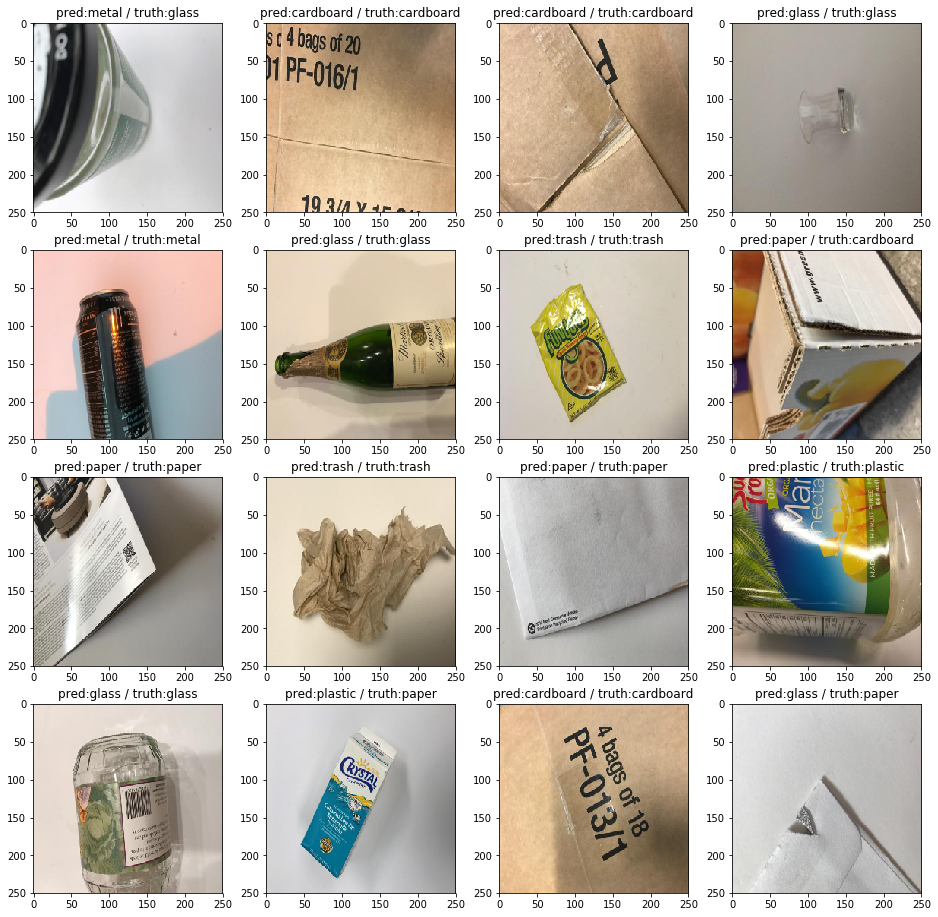

In [32]:
test_x, test_y = val_gen.__getitem__(1)

preds = model.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (class_labels[np.argmax(preds[i])], class_labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])

Accracy vs Epoch Plot. Referenced from https://mohitatgithub.github.io/2018-03-28-MNIST-Image-Classification-with-CNN-&-Keras/


As we can see the model accuracy was relatively high when training but upon validation the model was not able to yeild as very high accuracy. I think this is due to the relatively small size of the dataset containing the different labelled recycled trash images. There were only about 2500 spread amongst 6 classes.

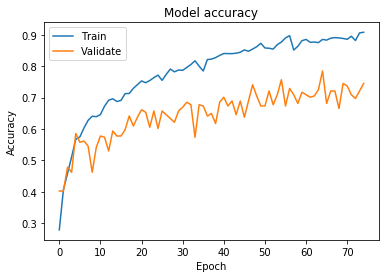

In [33]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

Loss vs Epoch Plot

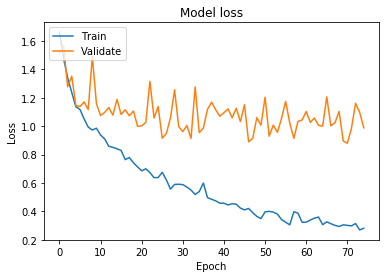

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

Save model for later use

In [35]:
model.save('recyclableClassification.hdf5')